<img style="float:left" width="70%" src="pics/escudo_COLOR_1L_DCHA.png">
<img style="float:right" width="15%" src="pics/PythonLogo.svg">
<br style="clear:both;">

# Evaluación de la base de datos *Drug classification*

En este *Notebook* se debe realizar el trabajo para obtener la tasa de clasificación sobre la base de datos de **Kaggle** de *clasificación de drogas*, utilizando el método de clasificación de **Support Vector Machines** (**SVM**), con parámetros $(C,\gamma)$ obtenidos mediante *búsqueda en rejilla* (*grid search*).

## Docentes
- Pedro Latorre Carmona

## Alumno
- Álvaro Manjón Vara

### Curso
- 2022-2023

Esta base de datos la podéis encontrar en:

https://www.kaggle.com/datasets/prathamtripathi/drug-classification

No obstante, en el fichero comprimido de la práctica, tenéis el correspondiente fichero *.csv* en la carpeta *DrugClassification*.

Cuando abráis dicho fichero, por ejemplo, con **openoffice**, veréis que tiene el siguiente aspecto:

<img src="pics/DCHowItLooksLike.png">

Lo primero que tenéis que hacer es convertir aquellas columnas que tengan valores no numéricos, a equivalentes numéricos con los que poder trabajar. Eso incluye la última columna, que debe ser considerada como la columna de las etiquetas. 

El conjunto de los objetivos es el mismo que en el caso de la práctica 2 de primera convocatoria, y se evaluará de la misma forma.

**IMPORTANTE**

Tenéis que hacer el mismo tipo de estudio que en el caso de la práctica 2 de la primera convocatoria, pero en este caso, para esta base de datos.

In [194]:
'''
Importación de librerías
'''
import pandas as pd
import numpy as np
import pickle
import os

from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [195]:
'''
Datos
'''

path = "./DrugClassification"
filename = path + os.sep + "DrugClassification200patients.csv"

### Carga del fichero csv como un *data frame*

In [196]:
# Utilizad la opción "pd.read_csv"
df = pd.read_csv(filename)

In [197]:
# Visualizad el "data frame" usando la opción "display"
display(df)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


## Creación de los conjuntos **X** e **y**

Una vez creado el data frame, tenéis que crear los conjuntos $\mathbf{X}$ e $\mathbf{Y}$, del que luego se crea sus correspondientes conjuntos de **entrenamiento** y **test**. 

In [198]:
columnasATransformar = list(df.select_dtypes(include=['category', 'object']))
# Transformación de los valores no numéricos a numéricos
encoder = LabelEncoder()
for feat in columnasATransformar:
    try:
        df[feat] = encoder.fit_transform(df[feat])
    except:
        print("Error transformando " + feat)

display(df)

y = df["Drug"].values
caract_cols = ["Age", "Sex", "BP", "Cholesterol", "Na_to_K"]
X_all = df[caract_cols].values

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,3
2,47,1,1,0,10.114,3
3,28,0,2,0,7.798,4
4,61,0,1,0,18.043,0
...,...,...,...,...,...,...
195,56,0,1,0,11.567,3
196,16,1,1,0,12.006,3
197,52,1,2,0,9.894,4
198,23,1,2,1,14.020,4


In [199]:
print(X_all.shape)

(200, 5)


In [200]:
'''
Listado de datos y nombres
'''

datasets = [(X_all,y)]
dataset_names = ["Data All"]

print(datasets)

[(array([[23.   ,  0.   ,  0.   ,  0.   , 25.355],
       [47.   ,  1.   ,  1.   ,  0.   , 13.093],
       [47.   ,  1.   ,  1.   ,  0.   , 10.114],
       [28.   ,  0.   ,  2.   ,  0.   ,  7.798],
       [61.   ,  0.   ,  1.   ,  0.   , 18.043],
       [22.   ,  0.   ,  2.   ,  0.   ,  8.607],
       [49.   ,  0.   ,  2.   ,  0.   , 16.275],
       [41.   ,  1.   ,  1.   ,  0.   , 11.037],
       [60.   ,  1.   ,  2.   ,  0.   , 15.171],
       [43.   ,  1.   ,  1.   ,  1.   , 19.368],
       [47.   ,  0.   ,  1.   ,  0.   , 11.767],
       [34.   ,  0.   ,  0.   ,  1.   , 19.199],
       [43.   ,  1.   ,  1.   ,  0.   , 15.376],
       [74.   ,  0.   ,  1.   ,  0.   , 20.942],
       [50.   ,  0.   ,  2.   ,  0.   , 12.703],
       [16.   ,  0.   ,  0.   ,  1.   , 15.516],
       [69.   ,  1.   ,  1.   ,  1.   , 11.455],
       [43.   ,  1.   ,  0.   ,  0.   , 13.972],
       [23.   ,  1.   ,  1.   ,  0.   ,  7.298],
       [32.   ,  0.   ,  0.   ,  1.   , 25.974],
       [57.   ,  1

In [201]:
'''
Definición del espacio de búsqueda para la optimización de los parámetros de SVM
'''

# Para definir el rango de "C" y de "gamma", tenéis que usar la opción "np.logspace", cubriendo, para "C", 
# desde 1.0e-2 hasta 1.0e+10, y para "gamma", desde 1.0e-9, hasta 1.0e+3.

C_range = np.logspace(-3, 2, num=6)
gamma_range = np.logspace(-3, 2, num=6)

param_grid_svm = dict(gamma=gamma_range, C=C_range)
nested_cv = 5

grid_svm = GridSearchCV(SVC(), param_grid=param_grid_svm, cv=nested_cv)

In [202]:
# Aquí se muestra el rango de valores a considerar
C_range, gamma_range

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]))

In [203]:
'''
Conjunto de clasificadores usados, así como sus nombres.
'''

cls_names = ["SVM"]

classifiers = [
    make_pipeline(StandardScaler(), grid_svm)]

In [204]:
# Método que ejecuta los clasificadores y devuelve las etiquetas predichas correspondientes.

from sklearn.model_selection import train_test_split

def predictions(model,X_train,y_train,X_test,y_test):    
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    return y_test, y_pred

In [205]:
def predictions_model(X_train,y_train,X_test, y_test,model):
        '''
        Predicciones con un modelo y un conjunto de datos (X e y), para obtener posteriormente las medidas que se quieren
        
        Parámetros
        ----------
        X: numpy.array
            Conjunto (características)
        Y: numpy.array
            Dataset (etiquetas)
        model: scikit_model
            modelo a entrenar
        num_folds: int
            Número de "particiones" de la validación cruzada ("k-fold" cross validation)
        
        Devuelve
        -------
        array 
            array de predicciones
        '''
        print('\t'+str(model)[:20], end=' - ')
        y_test,preds = predictions(model,X_train,y_train,X_test,y_test)
        print('OK')
        
        return y_test,preds

In [206]:
def run_all_save(filename, test_size):
    '''
    Realiza la validación cruzada de todos los modelos y conjuntos de datos.
        
        
    Parámetros
    ----------
    num_folds: int
        Igual que antes
    filename: string
        Nombre del fichero que guardará las "predicciones"
        
        
    El par X_train, y_train son los atributos y clases del conjunto de entrenamiento (70% de los ejemplos)
    El par X_test, y_test son los atributos y clases del conjunto de test (30% de los ejemplos)

    stratify (estratificar) significa que se quiere que haya la misma proporcion de cada una de las clases
    tanto en entrenamiento como en test, es decir, no es una partición completamente aleatoria.
    
    ''' 
    
    all_preds = {}

    for dataset,dataset_name in zip(datasets, dataset_names):
        print(dataset_name)
        X,y = dataset
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42, stratify = y)
        
        for model,cls_name in zip(classifiers,cls_names):
            print(cls_name)
            y_test,preds = predictions_model(X_train,y_train,X_test,y_test,model)
            all_preds[(dataset_name,cls_name)]=(y_test,preds)

    all_preds["cls_names"]=cls_names
    all_preds["dataset_names"]=dataset_names

    with open(filename, 'wb') as fp:
         pickle.dump(all_preds, fp)   

In [207]:
'''
All the predictions are going to be saved in a Python dictionary for 
further analysis.
'''

filename = 'PrediccionesDrugClassification.obj'

In [208]:
# Run the experiments

run_all_save(filename, 0.5)
run_all_save('PrediccionesDrugClassification_10_90.obj', 0.9)
run_all_save('PrediccionesDrugClassification_20_80.obj', 0.8)
run_all_save('PrediccionesDrugClassification_30_70.obj', 0.7)
run_all_save('PrediccionesDrugClassification_40_60.obj', 0.6)
run_all_save('PrediccionesDrugClassification_50_50.obj', 0.5)
run_all_save('PrediccionesDrugClassification_60_40.obj', 0.4)
run_all_save('PrediccionesDrugClassification_70_30.obj', 0.3)
run_all_save('PrediccionesDrugClassification_80_20.obj', 0.2)
run_all_save('PrediccionesDrugClassification_90_10.obj', 0.1)

Data All
SVM
	Pipeline(steps=[('st - OK
Data All
SVM
	Pipeline(steps=[('st - OK
Data All
SVM
	Pipeline(steps=[('st - 

/Users/alvaro/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/alvaro/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


OK
Data All
SVM
	Pipeline(steps=[('st - OK
Data All
SVM
	Pipeline(steps=[('st - OK
Data All
SVM
	Pipeline(steps=[('st - OK
Data All
SVM
	Pipeline(steps=[('st - OK
Data All
SVM
	Pipeline(steps=[('st - OK
Data All
SVM
	Pipeline(steps=[('st - OK
Data All
SVM
	Pipeline(steps=[('st - OK


# Análisis de los resultados

Si los experimentos se han realizado previamente, sólo es necesario ejecutar el *notebook* desde esta parte. 

Los resultados se *cargarían* desde el disco duro.

In [209]:
import pickle
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np

In [210]:
# Función que debe evaluar los resultados de clasificación.

def evalua(y_test, y_pred):
    return accuracy_score(y_test, y_pred)

In [211]:
def conf_mat_df(cm,labels):
    '''
    Creación de una matriz de confusión en un DataFrame
        
        
    Parámetros
    ----------
    cm: ndarray 2D
        matriz de confusión
    labels: lista
        Lista de nombres de clase
        
    Return DataFrame
    -------
    
    ''' 

    return (pd.DataFrame(cm,index=labels, columns=labels)
          .rename_axis("actual")
          .rename_axis("predicted", axis=1))

In [212]:
def get_results(filename):
    '''
    Carga el fichero con las predicciones.
    Calcula la "accuracy", la matriz de confusión, y otras. 
        
        
    Parámetros
    ----------
    filename: string
        Nombre del fichero que guarda las predicciones
        
    Return
    diccionario
        Un diccionario de pares key:values
    -------
    
    ''' 

    with open(filename, 'rb') as fp:
        all_preds = pickle.load(fp)

    cls_names = all_preds.pop("cls_names")
    dataset_names = all_preds.pop("dataset_names")

    data_cls_pairs = list(all_preds.keys())
    data_cls_pairs.sort()

    results = {}


    acc_df = pd.DataFrame(index=dataset_names, columns=cls_names)

    ## A DataFrame is created to store the accuracy in each clase
    for dataset in dataset_names:
        results[(dataset,"acc")] = pd.DataFrame(columns=cls_names)


    for dataset_name,cls_name in data_cls_pairs:

        #print(dataset_name,cls_name)
        y_true, y_pred = all_preds[(dataset_name,cls_name)]
        labels = list(np.unique(y_true))

        acc = evalua(y_true, y_pred)
        # Fill accuracy dataframe
        acc_df.at[dataset_name,cls_name]=acc

        # Get conf_mat
        cm = confusion_matrix(y_true, y_pred)
        cm_df = conf_mat_df(cm,labels)
        results[(dataset_name,cls_name,"cm")] = cm_df
        
        # Get classification report
        report = classification_report(y_true, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        results[(dataset_name,cls_name,"report")] = report_df

        # Acc per class
        cm_dig = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_dig = cm_dig.diagonal()

        dfi = results[(dataset_name,"acc")]
        dfi[cls_name]=pd.Series(cm_dig,labels)    
        results[(dataset_name,"acc")]=dfi.copy()


    results["Acc"] = acc_df
    return results
        
        
results = get_results(filename)

In [213]:
df_total = results["Acc"].astype(float)
df_conf = results[("Data All","SVM","cm")].astype(float)
df_report = results[("Data All","SVM","report")].astype(float)

In [214]:
df_total

,SVM
Data All,0.94


In [215]:
df_conf

predicted,0,1,2,3,4
actual,,,,,
0,43.0,0.0,0.0,1.0,2.0
1,0.0,11.0,0.0,0.0,0.0
2,1.0,2.0,5.0,0.0,0.0
3,0.0,0.0,0.0,8.0,0.0
4,0.0,0.0,0.0,0.0,27.0


In [216]:
df_report.round(4)[["precision","recall","f1-score"]]

,precision,recall,f1-score
0,0.9773,0.9348,0.9556
1,0.8462,1.0000,0.9167
2,1.0000,0.6250,0.7692
3,0.8889,1.0000,0.9412
4,0.9310,1.0000,0.9643
accuracy,0.9400,0.9400,0.9400
macro avg,0.9287,0.9120,0.9094
weighted avg,0.9451,0.9400,0.9376


---
## Análisis posteriores

En este apartado vas a tener que buscar información que te permita obtener lo que se pregunta en los tres puntos siguientes:

1. Estudia el efecto que tiene en la tasa de clasificación diferentes tipos de porcentajes de partición del conjunto, en conjunto de *entrenamiento* y de *test*. Puedes considerar, por ejemplo, los siguientes (normenclatura: (entrenamiento-test))

    - $50\%-50\%$
    - $60\%-40\%$
    - $70\%-30\%$
    - $80\%-20\%$

In [217]:
resultados10_90 = get_results('PrediccionesDrugClassification_10_90.obj')
resultados20_80 = get_results('PrediccionesDrugClassification_20_80.obj')
resultados30_70 = get_results('PrediccionesDrugClassification_30_70.obj')
resultados40_60 = get_results('PrediccionesDrugClassification_40_60.obj')
resultados50_50 = get_results('PrediccionesDrugClassification_50_50.obj')
resultados60_40 = get_results('PrediccionesDrugClassification_60_40.obj')
resultados70_30 = get_results('PrediccionesDrugClassification_70_30.obj')
resultados80_20 = get_results('PrediccionesDrugClassification_80_20.obj')
resultados90_10 = get_results('PrediccionesDrugClassification_90_10.obj')

datos = [resultados10_90["Acc"], resultados20_80["Acc"], resultados30_70["Acc"], resultados40_60["Acc"], resultados50_50["Acc"], resultados60_40["Acc"], resultados70_30["Acc"], resultados80_20["Acc"], resultados90_10["Acc"]]
df_total = pd.concat(datos)
df_total.index = ["10-90", "20-80", "30-70", "40-60", "50-50", "60-40", "70-30", "80-20", "90-10"]
print(df_total)

            SVM
10-90  0.738889
20-80   0.85625
30-70  0.728571
40-60  0.908333
50-50      0.94
60-40    0.9125
70-30  0.883333
80-20     0.975
90-10      0.95


2. Haz una representación gráfica con el valor de la tasa de acierto en función de diferentes porcentajes de partición del conjunto


[]

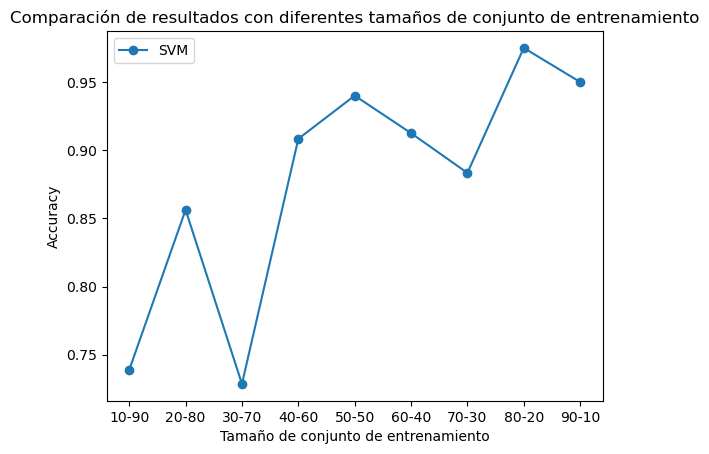

In [218]:
plt.title("Comparación de resultados con diferentes tamaños de conjunto de entrenamiento")
plt.plot(df_total, marker='o')
plt.ylabel("Accuracy")
plt.xlabel("Tamaño de conjunto de entrenamiento")
plt.legend(df_total.columns)
plt.plot()

3. Programa la forma de ejecutar los dos métodos de clasificación, de tal forma que se ejecuten ambos $10$ veces, y se muestre la representación gráfica del punto $2$, pero en este caso considerando su valor medio y desviación estándar.

    - Un ejemplo de gráfica en la que se representaría la media y la desviación estándar sería de la siguiente forma:

    <img src="pics/GraficosBarrasError.png" width="50%">
    

In [219]:
from statistics import mean, pstdev

resultados_svm = []

resultados_svm.append(resultados10_90["Acc"])
resultados_svm.append(resultados20_80["Acc"])
resultados_svm.append(resultados30_70["Acc"])
resultados_svm.append(resultados40_60["Acc"])
resultados_svm.append(resultados50_50["Acc"])
resultados_svm.append(resultados60_40["Acc"])
resultados_svm.append(resultados70_30["Acc"])
resultados_svm.append(resultados80_20["Acc"])
resultados_svm.append(resultados90_10["Acc"])

svm_acc_media = mean(resultados_svm)
svm_acc_desv = pstdev(resultados_svm)

print(svm_acc_media)
print(svm_acc_desv)

TypeError: can't convert type 'DataFrame' to numerator/denominator